In [ ]:
%pip install pytorch-forecasting
from pathlib import Path
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import lightning.pytorch as pl
import pytorch_forecasting.data.encoders as pf_encoders
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.data import TorchNormalizer

ROOT = Path.cwd().parents[0]              
DATA_DIR = ROOT / "data"
ARTIFACTS_DIR = ROOT / "artifacts" / "tft_nhits"
(ARTIFACTS_DIR / "checkpoints").mkdir(parents=True, exist_ok=True)
(ARTIFACTS_DIR / "logs").mkdir(parents=True, exist_ok=True)
(ARTIFACTS_DIR / "predictions").mkdir(parents=True, exist_ok=True)

ACCELERATOR = "gpu" if torch.cuda.is_available() else "cpu"
DEVICES = 1
print("Artifacts directory:", ARTIFACTS_DIR)
print("accelerator:", ACCELERATOR)

Seed set to 42


Loading master_dataset.csv...
  Dropped 0 rows with NaN target. Remaining: 26304
  Final shape: (26304, 65)
  Time range: 2022-12-31 23:00:00+00:00 → 2025-12-31 22:00:00+00:00
  Train: 13129 rows (up to 2024-07-01)
  Val:   2208 new rows (2024-07-01 → 2024-10-01)
  Test:  10967 new rows (2024-10-01 → end)
  min_val_pred_idx:  13129  (val windows start at TRAIN_END)
  min_test_pred_idx: 15337 (test windows start at VAL_END)

Building TimeSeriesDataSets...
  Train batches: 202, Val batches: 18, Test batches: 86

Building TimeSeriesDataSets...
  Train batches: 202, Val batches: 18, Test batches: 86

Building TimeSeriesDataSets...
  Train batches: 202, Val batches: 18, Test batches: 86

Evaluating models on test set...


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
2026-02-21 23:42:39.181763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been regist

x keys: ['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale']
  Seasonal Naive (t-24) MAE:  0.0668 kg CO₂/kWh
  Seasonal Naive (t-24) RMSE: 0.0920 kg CO₂/kWh

TEST SET METRICS — TFT
  MAE:  0.0364 kg CO₂/kWh
  RMSE: 0.0459 kg CO₂/kWh
  MAPE: 27.68%
  MAE 1–24h:    0.0354
  MAE 25–72h:   0.0364
  MAE 73–168h:  0.0366
  Worst windows saved to predictions/tft_worst_windows.csv
  Saved plots to predictions/tft_*.png


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


x keys: ['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale']
  Seasonal Naive (t-24) MAE:  0.0670 kg CO₂/kWh
  Seasonal Naive (t-24) RMSE: 0.0923 kg CO₂/kWh

TEST SET METRICS — NHITS
  MAE:  0.0522 kg CO₂/kWh
  RMSE: 0.0659 kg CO₂/kWh
  MAPE: 39.63%
  MAE 1–24h:    0.0429
  MAE 25–72h:   0.0513
  MAE 73–168h:  0.0551
  Worst windows saved to predictions/nhits_worst_windows.csv
  Saved plots to predictions/nhits_*.png

MODEL COMPARISON
Metric              TFT        NHiTS
------------------------------------
MAE              0.0364       0.0522  kg/kWh
RMSE             0.0459       0.0659  kg/kWh
MAPE            27.6837      39.6261  %


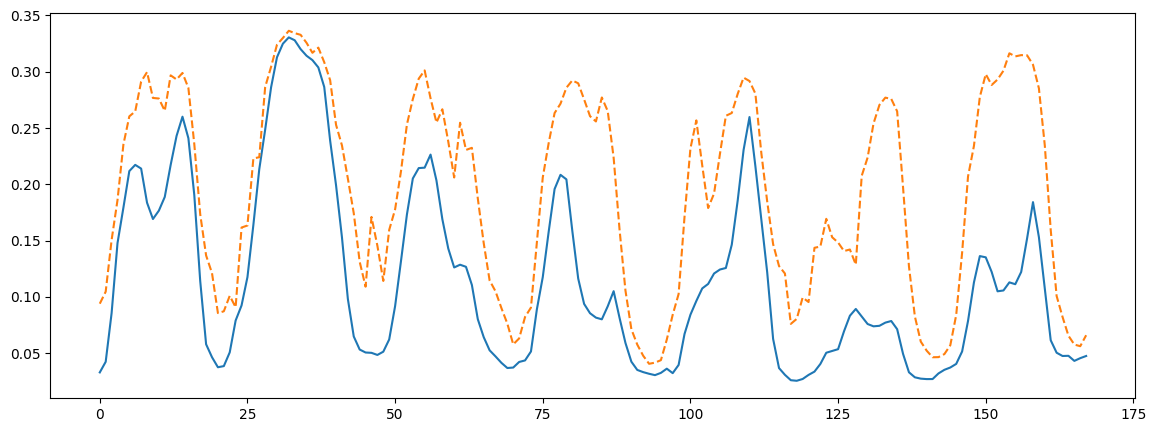

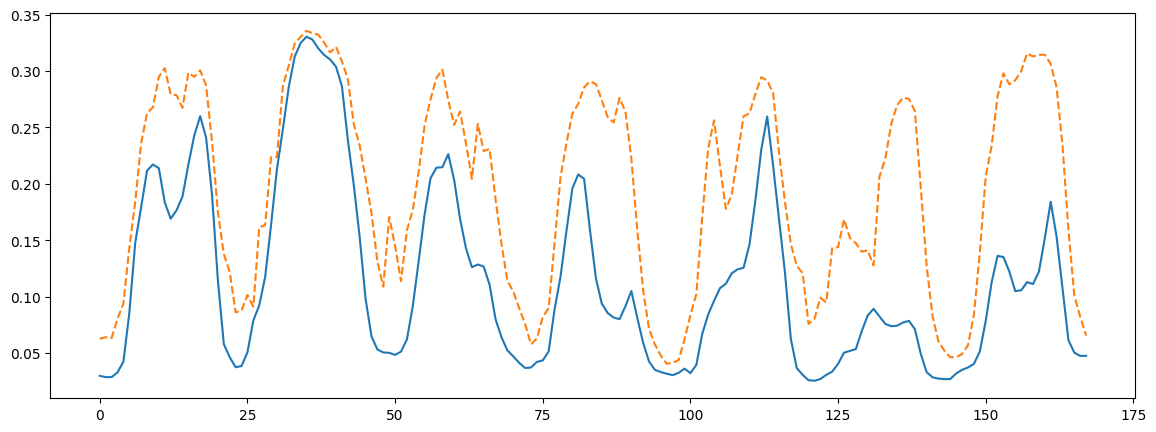

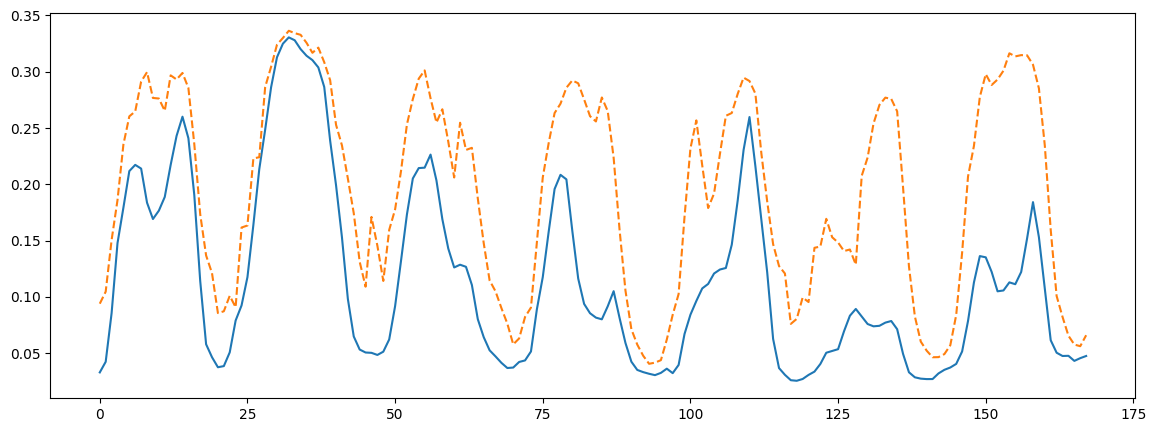

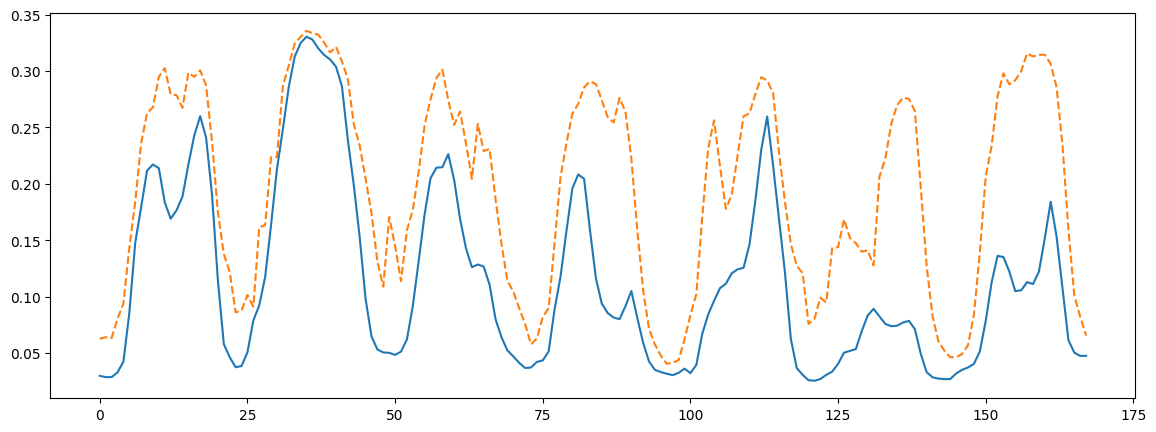

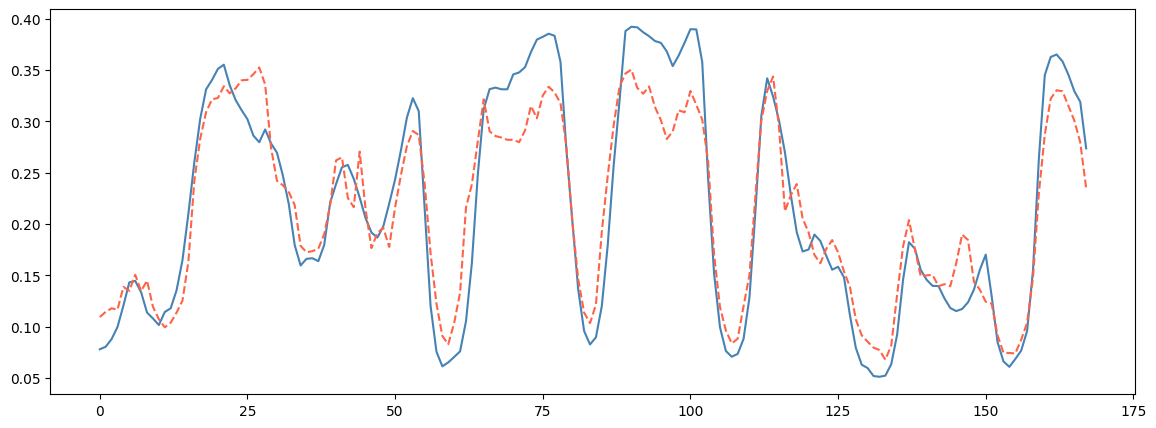

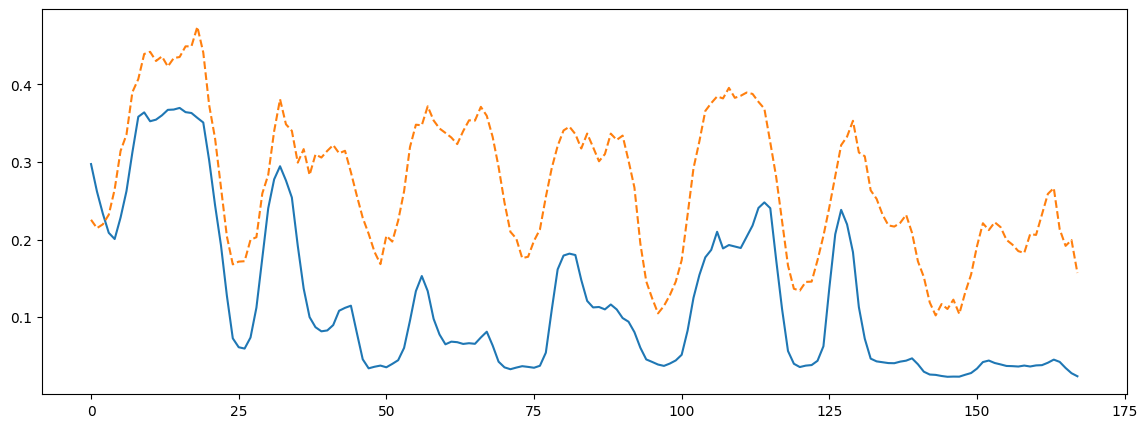

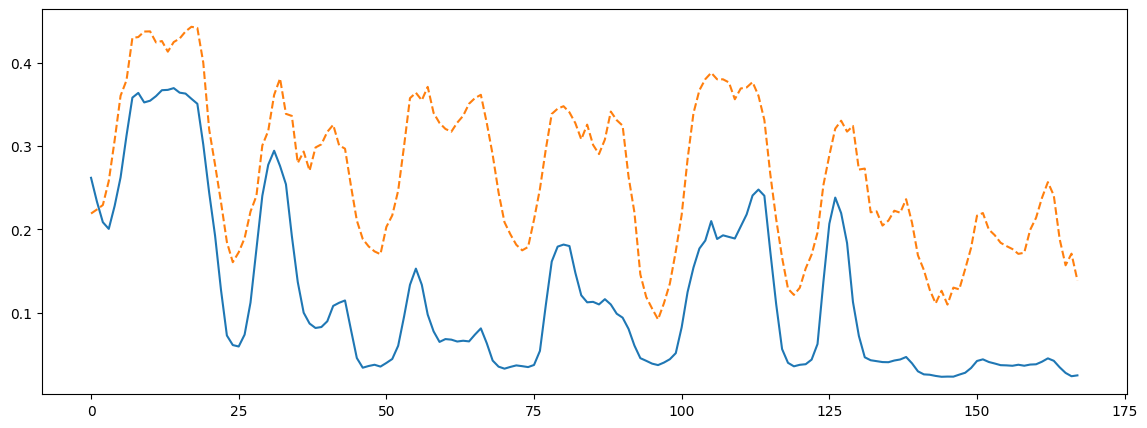

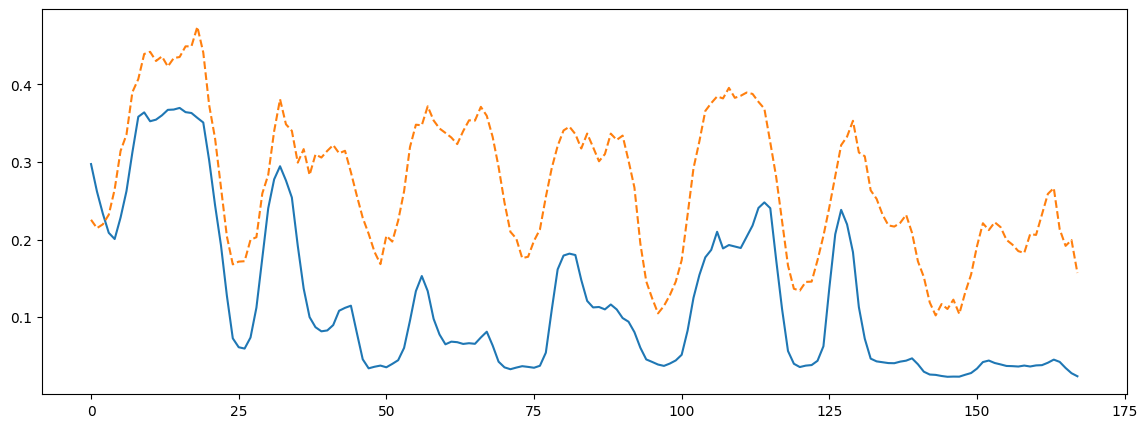

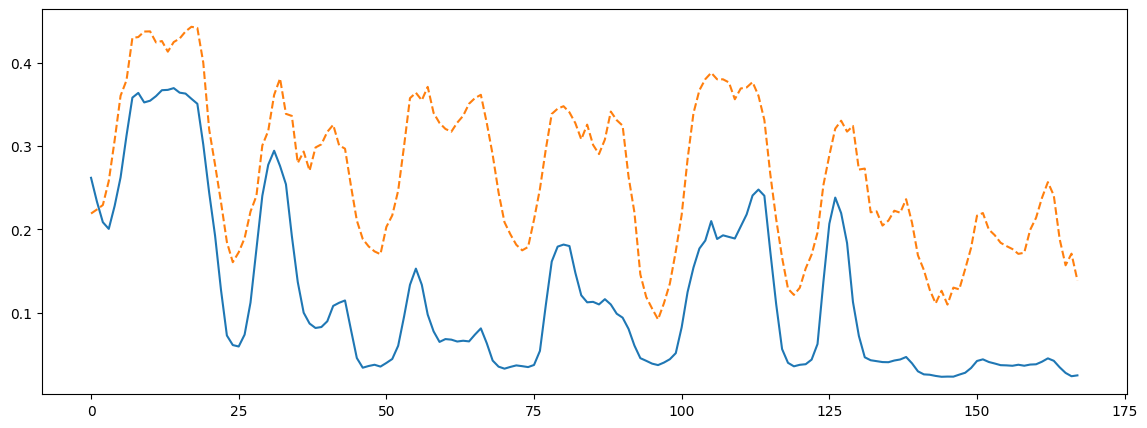

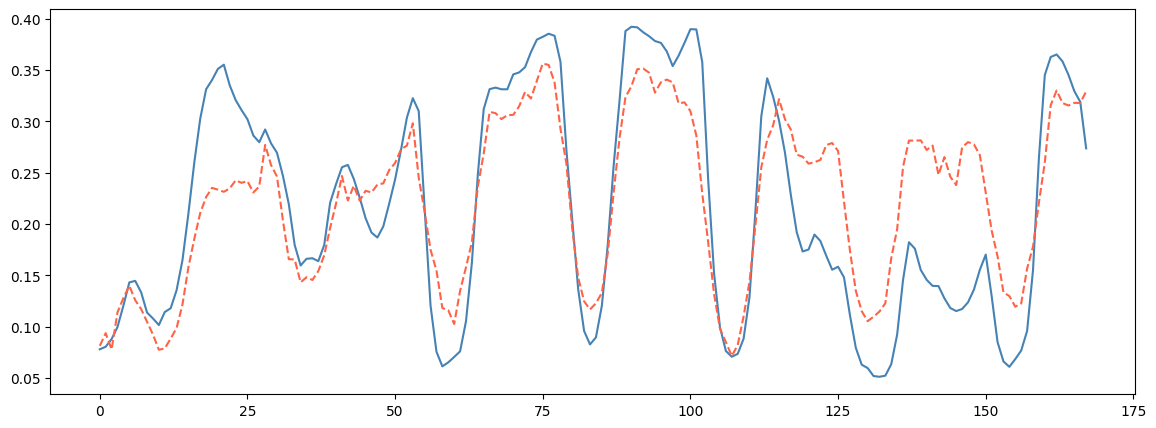

In [ ]:

"""
train_model.py

Production-quality CO₂ factor forecasting with Deep Learning.
Predicts next 168 hours (7 days, 1h resolution).

Architecture:
  - PRIMARY:  Temporal Fusion Transformer (TFT) — state-of-the-art for multivariate
              time series with known future covariates (weather forecast)
  - BASELINE: Neural Hierarchical Interpolation for Time Series (N-HiTS) — for comparison and report

Why TFT?
  - Natively handles "known future" inputs (weather forecast, time features)
  - Attention mechanism → interpretable feature importance per time step
  - Outputs prediction intervals (quantiles) — useful for uncertainty estimation
  - Proven best-in-class on energy forecasting benchmarks

Framework: PyTorch Lightning + PyTorch Forecasting (pip install pytorch-forecasting)

Input:  master_dataset.csv/openmeteo_forecast_7days.csv (from collect_data.py)
Output: checkpoints/tft_best.ckpt & nhits_best.ckpt 
        predictions/forecast_168h.csv
"""
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, BaseModelWithCovariates
from pytorch_forecasting.data import GroupNormalizer, TorchNormalizer
from pytorch_forecasting.metrics import QuantileLoss, MAE, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from forecasting.collect_data import add_time_features

ROOT = Path(r"C:\Users\kyube\co2-forecasting")
checkpoint_dir = ARTIFACTS_DIR / "checkpoints"
log_dir = ARTIFACTS_DIR / "logs"




# ══════════════════════════════════════════════════════════════════
# CONFIG
# ══════════════════════════════════════════════════════════════════

HORIZON   = 168          # 7 days × 24h — prediction target
LOOKBACK  = 168 * 2      # 2 weeks of history as encoder context
BATCH_SIZE = 64          #128/256
MAX_EPOCHS = 50          # EarlyStopping will cut this short
LEARNING_RATE = 3e-4

# Train/val/test split (chronological — never shuffle time series!)
TRAIN_END = "2024-07-01"   # ~18 months for training
VAL_END   = "2024-10-01"   # 3 months validation
# Test = 2024-10-01 → 2025-12-31 (last ~15 months, unseen)

TARGET = "co2_emissionfactor"

# Features known in the PAST (observed, not forecastable)
# These go into the encoder only
PAST_COVARIATES = [
    "solar_volume", "solar_capacity",
    "wind_volume",  "wind_capacity",
    "offwind_volume", "offwind_capacity",
    "biomass_volume", "waste_volume",
    "gas_volume",   "coal_volume",
    "nucl_volume",
    "co2_emissionfactor_was_missing",
    "solar_volume_was_missing",
    "wind_volume_was_missing",
]

# Features known in the FUTURE (time features + weather forecast)
# TFT uses these for both encoder AND decoder — key advantage over LSTM
FUTURE_COVARIATES = [
    # Time features (always known deterministically)
    "sin_hour", "cos_hour",
    "sin_dow",  "cos_dow",
    "sin_doy",  "cos_doy",
    "sin_month","cos_month",
    "hour", "dow", "month",
    "is_daylight",
    # Weather forecast (from Open-Meteo ECMWF, available 7 days ahead)
    "weather_shortwave_radiation",
    "weather_direct_normal_irradiance",
    "weather_diffuse_radiation",
    "weather_cloud_cover",
    "weather_cloud_cover_low",
    "weather_wind_speed_10m",
    "weather_wind_speed_100m",
    "weather_wind_direction_100m",
    "weather_temperature_2m",
    "weather_apparent_temperature",
    "weather_precipitation",
]

# Static features (constant per "group" — here we have one group: Netherlands)
STATIC_CATEGORICALS = ["country"]  # single group, but TFT requires at least one static categorical for embedding

# ══════════════════════════════════════════════════════════════════
# PART 1: DATA PREPARATION
# ══════════════════════════════════════════════════════════════════

def load_and_prepare(path="../data/master_dataset.csv"):
    """
    Load master dataset, add required columns for TimeSeriesDataSet.
    """
    print("Loading master_dataset.csv...")
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index, utc=True)
    df = df.sort_index()

    # Drop rows where target is still NaN after fill (long gaps)
    before = len(df)
    df = df.dropna(subset=[TARGET])
    print(f"  Dropped {before - len(df)} rows with NaN target. Remaining: {len(df)}")

    # PyTorch Forecasting requires:
    #   - integer time_idx (0, 1, 2, ...)
    #   - group_id column (for multi-series; here: single group)
    df = df.reset_index()
    if "validfrom" in df.columns:
        pass
    elif "index" in df.columns:
        df = df.rename(columns={"index": "timestamp"})
    elif "Unnamed: 0" in df.columns:
        df = df.rename(columns={"Unnamed: 0": "timestamp"})
    else:
        df = df.rename(columns={df.columns[0]: "timestamp"})

    df = df.rename(columns={"validfrom": "timestamp"})

    df["time_idx"] = (
        (df["timestamp"] - df["timestamp"].min())
        .dt.total_seconds()
        .div(3600)
        .round()
        .astype(int)
    )
    df["country"] = "NL"   # single group — required by TimeSeriesDataSet

    # Fill any remaining NaNs in covariates (weather edges, etc.)
    covariate_cols = PAST_COVARIATES + FUTURE_COVARIATES
    for c in covariate_cols:
        if c in df.columns:
            df[c]=df[c].ffill().fillna(0)
    #        df[c] = df[c].fillna(method="ffill").fillna(0)

    # Ensure correct dtypes
    df["country"] = df["country"].astype(str)
    df["hour"]    = df["hour"].astype(int)
    df["dow"]     = df["dow"].astype(int)
    df["month"]   = df["month"].astype(int)

    print(f"  Final shape: {df.shape}")
    print(f"  Time range: {df['timestamp'].min()} → {df['timestamp'].max()}")
    return df

def make_splits(df):
    """Chronological train/val/test split — NO shuffling.
    Return the indices so that the window's val/test starts strictly after the boundaries.
    """
    train_end = pd.Timestamp(TRAIN_END, tz="UTC")
    val_end   = pd.Timestamp(VAL_END,   tz="UTC")

    train_df = df[df["timestamp"] < train_end].copy()
    val_df   = df[df["timestamp"] < val_end].copy()

    max_train_idx = int(train_df["time_idx"].max())
    max_val_idx   = int(val_df["time_idx"].max())

    # validation not to include windows that are entirely in train
    min_val_pred_idx  = int(df.loc[df["timestamp"] >= train_end, "time_idx"].min())

    # for test to be strictly out-of-sample starting from VAL_END
    min_test_pred_idx = int(df.loc[df["timestamp"] >= val_end, "time_idx"].min())

    print(f"  Train: {len(train_df)} rows (up to {TRAIN_END})")
    print(f"  Val:   {len(val_df) - len(train_df)} new rows ({TRAIN_END} → {VAL_END})")
    print(f"  Test:  {len(df) - len(val_df)} new rows ({VAL_END} → end)")
    print(f"  min_val_pred_idx:  {min_val_pred_idx}  (val windows start at TRAIN_END)")
    print(f"  min_test_pred_idx: {min_test_pred_idx} (test windows start at VAL_END)")

    return df, max_train_idx, max_val_idx, min_val_pred_idx, min_test_pred_idx
    

def build_datasets(df, max_train_idx, max_val_idx, min_val_pred_idx, min_test_pred_idx):
    """
    Create PyTorch Forecasting TimeSeriesDataSet objects.

    IMPORTANT:
      - validation/test -> predict=False 
      - min_prediction_idx -> that windows start strictly after boundaries
    """
    past_cols   = [c for c in PAST_COVARIATES   if c in df.columns]
    future_cols = [c for c in FUTURE_COVARIATES if c in df.columns]

    training = TimeSeriesDataSet(
        df[df["time_idx"] <= max_train_idx],
        time_idx="time_idx",
        target=TARGET,
        group_ids=["country"],
        min_encoder_length=LOOKBACK // 2,
        max_encoder_length=LOOKBACK,
        min_prediction_length=HORIZON,
        max_prediction_length=HORIZON,
        static_categoricals=["country"],
        time_varying_known_reals=future_cols,
        time_varying_unknown_reals=[TARGET] + past_cols,
        target_normalizer=TorchNormalizer(method="robust", center=True),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=False,
    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df[df["time_idx"] <= max_val_idx],
        predict=False,
        stop_randomization=True,
        min_prediction_idx=min_val_pred_idx,   # <<< key
    )

    test = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=False,                          # IMPORTANT
        stop_randomization=True,
        min_prediction_idx=min_test_pred_idx,   # <<< key
    )

    train_loader = training.to_dataloader(train=True,   batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
    val_loader   = validation.to_dataloader(train=False, batch_size=BATCH_SIZE * 2, num_workers=2)
    test_loader  = test.to_dataloader(train=False,       batch_size=BATCH_SIZE * 2, num_workers=2)

    print(f"  Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")
    return training, train_loader, val_loader, test_loader
    

def build_datasets_nhits(df, max_train_idx, max_val_idx, min_val_pred_idx, min_test_pred_idx):
    """Separate dataset for NHiTS with fixed encoder length."""
    past_cols   = [c for c in PAST_COVARIATES   if c in df.columns]
    future_cols = [c for c in FUTURE_COVARIATES if c in df.columns]

    training = TimeSeriesDataSet(
        df[df["time_idx"] <= max_train_idx],
        time_idx="time_idx",
        target=TARGET,
        group_ids=["country"],
        min_encoder_length=LOOKBACK,
        max_encoder_length=LOOKBACK,
        min_prediction_length=HORIZON,
        max_prediction_length=HORIZON,
        static_categoricals=["country"],
        time_varying_known_reals=future_cols,
        time_varying_unknown_reals=[TARGET] + past_cols,
        target_normalizer=TorchNormalizer(method="robust", center=True),
        add_relative_time_idx=False,
        add_target_scales=False,
        add_encoder_length=False,
        allow_missing_timesteps=False,
    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df[df["time_idx"] <= max_val_idx],
        predict=False,
        stop_randomization=True,
        min_prediction_idx=min_val_pred_idx,    # <<< ключ
    )

    test = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=False,                          
        stop_randomization=True,
        min_prediction_idx=min_test_pred_idx,   # <<< key
    )

    train_loader = training.to_dataloader(train=True,   batch_size=BATCH_SIZE,     num_workers=2, pin_memory=True)
    val_loader   = validation.to_dataloader(train=False, batch_size=BATCH_SIZE*2,  num_workers=2)
    test_loader  = test.to_dataloader(train=False,       batch_size=BATCH_SIZE*2,  num_workers=2)

    return training, train_loader, val_loader, test_loader
    
# ══════════════════════════════════════════════════════════════════
# PART 2: TFT MODEL
# ══════════════════════════════════════════════════════════════════

def build_tft(training_dataset):
    """
    Build Temporal Fusion Transformer.

    Key hyperparameters:
      hidden_size:        main network width (larger = more capacity)
      attention_head_size: multi-head attention (interpretability)
      dropout:            regularization
      hidden_continuous_size: continuous variable embedding size
      loss:               QuantileLoss → gives prediction intervals [10%, 50%, 90%]
    """
    tft = TemporalFusionTransformer.from_dataset(
        training_dataset,
        learning_rate           = LEARNING_RATE,
        hidden_size             = 128,           # main model capacity
        attention_head_size     = 4,
        dropout                 = 0.1,
        hidden_continuous_size  = 32,
        loss                    = QuantileLoss(quantiles=[0.1, 0.5, 0.9]),
        log_interval            = 50,
        reduce_on_plateau_patience = 4,
        optimizer               = "adamw",
    )
    print(f"\nTFT parameters: {tft.size() / 1e3:.1f}k")
    return tft


def build_lstm_baseline(training_dataset):
    """
    NHiTS (Neural Hierarchical Interpolation for Time Series) baseline for comparison.
    Uses same dataset interface as TFT for fair comparison.
    """
    from pytorch_forecasting.models import NHiTS
    from pytorch_forecasting.metrics import MAE
    # NHiTS (Neural Hierarchical Interpolation for Time Series)
    # Better than plain LSTM for multi-step forecasting
    model = NHiTS.from_dataset(
        training_dataset,
        learning_rate  = LEARNING_RATE,
        weight_decay   = 1e-2,
        loss           = MAE(),
#        backcast_loss_ratio = 0.1,
        hidden_size    = 512,
        optimizer      = "adamw",
    )
    print(f"NHiTS parameters: {model.size() / 1e3:.1f}k")
    return model


# ══════════════════════════════════════════════════════════════════
# PART 3: TRAINING
# ══════════════════════════════════════════════════════════════════

def train_model(model, train_loader, val_loader, model_name="tft"):
    """Train with EarlyStopping, LR scheduling, and checkpointing."""
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("logs", exist_ok=True)

    callbacks = [
        EarlyStopping(
            monitor   = "val_loss",
            patience  = 4,           # stop if no improvement for 8 epochs
            mode      = "min",
            verbose   = True,
        ),
        ModelCheckpoint(
            dirpath   = f"{checkpoint_dir}/checkpoints",
            filename  = f"{model_name}_best",
            monitor   = "val_loss",
            mode      = "min",
            save_top_k = 1,
            verbose   = True,
        ),
        ModelCheckpoint(                  #
        dirpath    = f"{checkpoint_dir}/checkpoints",
        filename   = f"{model_name}_last",
        save_last  = True,
        save_top_k = 0,
        ),
        LearningRateMonitor(logging_interval="epoch"),
    ]

    trainer = pl.Trainer(
        max_epochs          = MAX_EPOCHS,
        accelerator         = "cuda",   # GPU if available, else CPU
        devices             = 1,
        gradient_clip_val   = 0.1,      # important for TFT stability
        callbacks           = callbacks,
        logger              = CSVLogger(f"{log_dir}/logs", name=model_name),
        enable_progress_bar = True,
        log_every_n_steps   = 50,
    )

    best_ckpt = f"{checkpoint_dir}/checkpoints/{model_name}_best.ckpt"
    resume_ckpt = f"{checkpoint_dir}/checkpoints/{model_name}_last.ckpt"
    
    if os.path.exists(resume_ckpt):
        print(f"Resuming {model_name} from last epoch...")
        trainer.fit(model, train_dataloaders=train_loader,
                    val_dataloaders=val_loader, ckpt_path=resume_ckpt)
    else:
        print(f"Starting {model_name} fresh...")
        trainer.fit(model, train_dataloaders=train_loader,
                    val_dataloaders=val_loader)

    print(f"\nBest checkpoint: {callbacks[1].best_model_path}")
    print(f"Best val_loss:   {callbacks[1].best_model_score:.4f}")
    return trainer, best_ckpt

# ══════════════════════════════════════════════════════════════════
# PART 4: EVALUATION
# ══════════════════════════════════════════════════════════════════

def evaluate(model, test_loader, trainer, df_test, model_name="tft"):
    """
    Evaluate on test set. Computes MAE, RMSE, MAPE per forecast horizon.
    Saves plots: predictions vs actuals + error by horizon step.
    """
    os.makedirs("predictions", exist_ok=True)

    # Get raw predictions (median = q50)
    predictions = model.predict(
    test_loader,
    return_y=True,
    return_x=True,                  
    trainer_kwargs={"accelerator": "auto"},
    )
    print("x keys:", list(predictions.x.keys()))
#    predictions = model.predict(test_loader, return_y=True, trainer_kwargs={"accelerator": "auto"})
#    y_pred = predictions.output[:, :, 1].numpy()   # quantile 0.5 (median)
    y_true = predictions.y[0].cpu().numpy()
    if predictions.output.dim() == 3:
        y_pred = predictions.output[:, :, 1].cpu().numpy()   # TFT — quantiles [q10, q50, q90]
    else:
        y_pred = predictions.output.cpu().numpy()             # NHiTS — just prediction

    abs_err = np.abs(y_pred - y_true)
    err_level = abs_err.reshape(-1)
    
    # Denormalize if needed (pytorch-forecasting handles this automatically in predict())
    
    # =========================
    # Seasonal naive baseline (t-24) — padding-safe
    # =========================
    
    x = predictions.x
    encoder_target = x["encoder_target"].detach().cpu().numpy()      # [N, max_enc_len]
    encoder_lengths = x["encoder_lengths"].detach().cpu().numpy()      # [N]
    y_true = predictions.y[0].detach().cpu().numpy()                # [N, H]

    y_naive = np.zeros_like(y_true)

    for h_idx in range(HORIZON):
        h = h_idx + 1
        if h <= 24:
        # хотим t-(24-h+1) внутри encoder, но берем по encoder_length (конец реальных данных)
            offset = (24 - h + 1)                      # 24..1
            idx = encoder_lengths - offset              # [N] indexes in encoder_target
        # если у кого-то encoder слишком короткий, fallback на последний реальный таргет
            idx = np.clip(idx, 0, encoder_target.shape[1] - 1)
            y_naive[:, h_idx] = encoder_target[np.arange(len(idx)), idx]
        else:
            y_naive[:, h_idx] = y_true[:, h_idx - 24]

    mae_naive  = np.nanmean(np.abs(y_naive - y_true))
    rmse_naive = np.sqrt(np.nanmean((y_naive - y_true) ** 2))

    print(f"  Seasonal Naive (t-24) MAE:  {mae_naive:.4f} kg CO₂/kWh")
    print(f"  Seasonal Naive (t-24) RMSE: {rmse_naive:.4f} kg CO₂/kWh")

    # Overall metrics
    mae  = abs_err.mean()
    rmse = np.sqrt((abs_err ** 2).mean())
    mape = (np.abs((y_pred - y_true) / (y_true + 1e-8))).mean() * 100
    
    print(f"\n{'='*50}")
    print(f"TEST SET METRICS — {model_name.upper()}")
    print(f"{'='*50}")
    print(f"  MAE:  {mae:.4f} kg CO₂/kWh")
    print(f"  RMSE: {rmse:.4f} kg CO₂/kWh")
    print(f"  MAPE: {mape:.2f}%")

    # Per-horizon metrics (MAE at each step h=1..168)
    mae_per_h  = abs_err.mean(axis=0)
    rmse_per_h = np.sqrt((abs_err ** 2).mean(axis=0))
    
    print(f"  MAE 1–24h:    {mae_per_h[:24].mean():.4f}")
    print(f"  MAE 25–72h:   {mae_per_h[24:72].mean():.4f}")
    print(f"  MAE 73–168h:  {mae_per_h[72:].mean():.4f}")


    true_level = y_true.reshape(-1)
    err_level = abs_err.reshape(-1)

    bins = pd.qcut(true_level, q=10, duplicates="drop")
    df_level = pd.DataFrame({"bin": bins.astype(str), "abs_err": err_level})
    level_mae = df_level.groupby("bin")["abs_err"].mean().reset_index()
    level_mae.to_csv(f"predictions/{model_name}_mae_by_true_decile.csv", index=False)

    # ==========================================
    # Worst forecast windows (top-10 by MAE)
    # ==========================================

    abs_err = np.abs(y_pred - y_true)
    window_mae = abs_err.mean(axis=1)  # MAE per 168h window

    # индексы худших окон
    worst_idx = np.argsort(-window_mae)[:10]

    worst_table = pd.DataFrame({
        "window_rank": np.arange(1, 11),
        "window_id": worst_idx,
        "window_mae": window_mae[worst_idx],
        })

    worst_table.to_csv(f"predictions/{model_name}_worst_windows.csv", index=False)
    print(f"  Worst windows saved to predictions/{model_name}_worst_windows.csv")

    # Saving 3 the worst windows as fugures
    for j, wi in enumerate(worst_idx[:3], start=1):
        plt.figure(figsize=(14,5))
        plt.plot(y_true[wi], label="Actual", linewidth=1.5)
        plt.plot(y_pred[wi], label="Predicted", linestyle="--", linewidth=1.5)

    # Q10/Q90 for TFT
    if predictions.output.dim() == 3:
        q10 = predictions.output[wi, :, 0].detach().cpu().numpy()
        q90 = predictions.output[wi, :, 2].detach().cpu().numpy()
        plt.fill_between(np.arange(HORIZON), q10, q90, alpha=0.2, label="80% interval")

    plt.title(f"{model_name.upper()} — Worst window #{j} (MAE={window_mae[wi]:.4f})")
    plt.xlabel("Hour ahead")
    plt.ylabel("CO₂ factor")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"predictions/{model_name}_worst_window_{j}.png", dpi=150)
    plt.close()

    
    # ── Plot 1: Predictions vs Actuals (first 2 weeks of test) ──
    fig, ax = plt.subplots(figsize=(14, 5))
    sample = 0   # 4th prediction window for a representative look
    ax.plot(y_true[sample], label="Actual CO₂ factor", color="steelblue", linewidth=1.5)
    ax.plot(y_pred[sample], label="Predicted (median)", color="tomato",   linewidth=1.5, linestyle="--")
    # Prediction interval (q10, q90)
    if predictions.output.dim() == 3:
        q10 = predictions.output[sample, :, 0].cpu().numpy()
        q90 = predictions.output[sample, :, 2].cpu().numpy()
        ax.fill_between(range(HORIZON), q10, q90, alpha=0.2, color="tomato", label="80% interval")
        ax.set_title(f"{model_name.upper()} — Predictions vs Actuals (168h window)")
        ax.set_xlabel("Hour")
        ax.set_ylabel("CO₂ factor [kg/kWh]")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"predictions/{model_name}_pred_vs_actual.png", dpi=150)
        plt.close()

    # ── Plot 2: MAE by forecast horizon step ──
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(range(1, HORIZON + 1), mae_per_h, color="steelblue", linewidth=1.5)
    ax.axvline(24,  color="gray", linestyle="--", alpha=0.5, label="24h")
    ax.axvline(72,  color="gray", linestyle=":",  alpha=0.5, label="72h")
    ax.axvline(168, color="gray", linestyle="-.", alpha=0.5, label="168h")
    ax.set_title(f"{model_name.upper()} — MAE by Forecast Horizon")
    ax.set_xlabel("Forecast horizon (hours ahead)")
    ax.set_ylabel("MAE [kg CO₂/kWh]")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"predictions/{model_name}_mae_by_horizon.png", dpi=150)
    plt.close()

    # Save metrics to CSV
    metrics_df = pd.DataFrame({
        "horizon_h": range(1, HORIZON + 1),
        "mae":  mae_per_h,
        "rmse": rmse_per_h,
    })
    metrics_df.to_csv(f"predictions/{model_name}_metrics_by_horizon.csv", index=False)

    print(f"  Saved plots to predictions/{model_name}_*.png")

    return {"mae": mae, "rmse": rmse, "mape": mape}


def compare_models(metrics_tft, metrics_nhits):
    """Print side-by-side comparison table."""
    print(f"\n{'='*50}")
    print("MODEL COMPARISON")
    print(f"{'='*50}")
    print(f"{'Metric':<10} {'TFT':>12} {'NHiTS':>12}")
    print("-" * 36)
    for k in ["mae", "rmse", "mape"]:
        unit = "%" if k == "mape" else "kg/kWh"
        print(f"{k.upper():<10} {metrics_tft[k]:>12.4f} {metrics_nhits[k]:>12.4f}  {unit}")


# ══════════════════════════════════════════════════════════════════
# PART 5: INFERENCE (actual 7-day forecast)
# ══════════════════════════════════════════════════════════════════

def run_inference_no_weather(
    best_ckpt_path: str,
    training_dataset: TimeSeriesDataSet,
    df_full: pd.DataFrame,
    target_col: str,
    lookback: int,
    horizon: int,
    country_col: str = "country",
    country_value: str = "NL",
    time_col: str = "timestamp",
):
    """
    168h "real future" inference WITHOUT weather:
      - uses last `lookback` hours as encoder context
      - creates future rows for next `horizon` hours
      - fills only deterministic time features (hour/dow/month etc.) via add_time_features()
      - outputs forecast for next `horizon` timestamps
    """

    # ---- 1) Load model
    model = TemporalFusionTransformer.load_from_checkpoint(best_ckpt_path)
    model.eval()

    # ---- 2) Prepare history context
    df_hist = df_full.sort_values(time_col).copy()
    last_ts = pd.to_datetime(df_hist[time_col].iloc[-1])

    df_context = df_hist.tail(lookback).copy()

    # ---- 3) Build future timestamps
    future_ts = pd.date_range(
        start=last_ts + pd.Timedelta(hours=1),
        periods=horizon,
        freq="H"
    )
    df_future = pd.DataFrame({time_col: future_ts})
    df_future[country_col] = country_value
    df_future[target_col] = np.nan  # unknown

    # ---- 4) Add deterministic time features for future rows
    # Must match your training feature engineering
    from collect_data import add_time_features
    df_future = add_time_features(df_future.set_index(time_col)).reset_index()
    df_future = df_future.rename(columns={"index": time_col})

    # ---- 5) Align time_idx with training data reference
    # Important: must be consistent with how you created time_idx in training.
    min_ts = pd.to_datetime(df_hist[time_col].min())
    df_future["time_idx"] = (
        (pd.to_datetime(df_future[time_col]) - min_ts)
        .dt.total_seconds()
        .div(3600)
        .round()
        .astype(int)
    )

    # Ensure context has time_idx too (if not already)
    if "time_idx" not in df_context.columns:
        df_context["time_idx"] = (
            (pd.to_datetime(df_context[time_col]) - min_ts)
            .dt.total_seconds()
            .div(3600)
            .round()
            .astype(int)
        )

    # ---- 6) Combine context + future
    df_combined = pd.concat([df_context, df_future], ignore_index=True)

    # ---- 7) If you had covariates in training that are not available in future,
    # you must provide them. Minimal safe approach: fill missing numeric columns with 0.
    # This avoids errors in TimeSeriesDataSet creation.
    needed_cols = set(training_dataset.data.columns)
    for col in needed_cols:
        if col not in df_combined.columns:
            df_combined[col] = 0

    # Fill NaNs in non-target columns
    for col in df_combined.columns:
        if col == target_col:
            continue
        if df_combined[col].dtype.kind in "biufc":  # numeric
            df_combined[col] = df_combined[col].fillna(0)

    # ---- 8) Create inference dataset/loader
    inference_ds = TimeSeriesDataSet.from_dataset(
        training_dataset,
        df_combined,
        predict=True,
        stop_randomization=True,
    )
    inference_loader = inference_ds.to_dataloader(train=False, batch_size=1, num_workers=0)

    # ---- 9) Predict
    preds = model.predict(inference_loader)

    # Handle quantile output if applicable
    # If preds is (1, horizon, n_quantiles): take q10/q50/q90. Otherwise point forecast.
    if hasattr(preds, "dim") and preds.dim() == 3 and preds.shape[-1] >= 3:
        y_q10 = preds[0, :, 0].detach().cpu().numpy()
        y_q50 = preds[0, :, 1].detach().cpu().numpy()
        y_q90 = preds[0, :, 2].detach().cpu().numpy()
    else:
        y_q50 = preds[0].detach().cpu().numpy() if hasattr(preds, "detach") else np.array(preds).squeeze()
        y_q10 = y_q50
        y_q90 = y_q50

    # ---- 10) Output
    result = pd.DataFrame({
        "timestamp": future_ts,
        "co2_forecast_q10": y_q10[:horizon],
        "co2_forecast_q50": y_q50[:horizon],
        "co2_forecast_q90": y_q90[:horizon],
    })

    os.makedirs("predictions", exist_ok=True)
    result.to_csv("predictions/co2_forecast_168h_noweather.csv", index=False)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(result["timestamp"], result["co2_forecast_q50"], label="Forecast (median)", linewidth=2)
    ax.fill_between(
        result["timestamp"],
        result["co2_forecast_q10"],
        result["co2_forecast_q90"],
        alpha=0.2,
        label="80% interval"
    )
    ax.set_title("CO₂ Factor — 7-Day Forecast (No Weather)")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("CO₂ factor [kg/kWh]")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig("predictions/co2_forecast_7days_noweather.png", dpi=150)
    plt.close()

    return result


# ══════════════════════════════════════════════════════════════════
# PART 5.2:
# ══════════════════════════════════════════════════════════════════
def run_inference_with_weather_forecast(
    best_ckpt_path: str,
    training_dataset: TimeSeriesDataSet,
    df_full: pd.DataFrame,
    weather_forecast_csv: str,              # <<< path to openmeteo_forecast_7days.csv
    target_col: str,
    lookback: int,
    horizon: int,
    country_col: str = "country",
    country_value: str = "NL",
    time_col: str = "timestamp",
):
    """
    168h real inference WITH weather forecast:
      - encoder: last `lookback` hours from df_full
      - decoder: next `horizon` hours with Open-Meteo forecast weather_* + deterministic time features
    """
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet

    # ---- 1) Load model
    model = TemporalFusionTransformer.load_from_checkpoint(best_ckpt_path)
    model.eval()

    # ---- 2) History (context)
    df_hist = df_full.sort_values(time_col).copy()
    df_context = df_hist.tail(lookback).copy()
    last_ts = pd.to_datetime(df_hist[time_col].iloc[-1])
    if last_ts.tzinfo is None:
        last_ts = last_ts.tz_localize("UTC")
    else:
        last_ts = last_ts.tz_convert("UTC")

    # ---- 3) Future timestamps
    future_ts = pd.date_range(
        start=last_ts + pd.Timedelta(hours=1),
        periods=horizon,
        freq="H",
        tz="UTC",
    )
    df_future = pd.DataFrame({time_col: future_ts})
    df_future[country_col] = country_value
    df_future[target_col] = np.nan  # unknown future target

    # ---- 4) Load Open-Meteo 7-day forecast and join
    df_wfc = pd.read_csv(weather_forecast_csv)
    # forecast file index might be saved as first column or as "validfrom"/"time"
    if "validfrom" in df_wfc.columns:
        df_wfc["validfrom"] = pd.to_datetime(df_wfc["validfrom"], utc=True)
        df_wfc = df_wfc.rename(columns={"validfrom": time_col})
    elif "time" in df_wfc.columns:
        df_wfc["time"] = pd.to_datetime(df_wfc["time"], utc=True)
        df_wfc = df_wfc.rename(columns={"time": time_col})
    elif time_col in df_wfc.columns:
        df_wfc[time_col] = pd.to_datetime(df_wfc[time_col], utc=True)
    else:
        # common case: first unnamed column is datetime index
        first = df_wfc.columns[0]
        df_wfc[first] = pd.to_datetime(df_wfc[first], utc=True)
        df_wfc = df_wfc.rename(columns={first: time_col})

    # keep only weather_*
    weather_cols = [c for c in df_wfc.columns if c.startswith("weather_")]
    df_wfc = df_wfc[[time_col] + weather_cols].drop_duplicates(subset=[time_col])

    # align to exactly the horizon timestamps
    df_future = df_future.merge(df_wfc, on=time_col, how="left")

    # If forecast does not fully cover horizon (rare), forward-fill then 0-fill
    for c in weather_cols:
        df_future[c] = df_future[c].ffill().fillna(0)

    # ---- 5) Add deterministic time features for future rows (must match training)
    # Use the exact same function from collect_data.py
    from collect_data import add_time_features
    df_future = add_time_features(df_future.set_index(time_col)).reset_index()

    # ---- 6) Create consistent time_idx (same reference as training)
    min_ts = pd.to_datetime(df_hist[time_col].min())
    if min_ts.tzinfo is None:
        min_ts = min_ts.tz_localize("UTC")
    else:
        min_ts = min_ts.tz_convert("UTC")

    def _make_time_idx(s):
        s = pd.to_datetime(s)
        if getattr(s.dt, "tz", None) is None:
            s = s.dt.tz_localize("UTC")
        else:
            s = s.dt.tz_convert("UTC")
        return (
            (s - min_ts)
            .dt.total_seconds()
            .div(3600)
            .round()
            .astype(int)
        )

    if "time_idx" not in df_context.columns:
        df_context["time_idx"] = _make_time_idx(df_context[time_col])

    df_future["time_idx"] = _make_time_idx(df_future[time_col])

    # ---- 7) Combine context + future
    df_combined = pd.concat([df_context, df_future], ignore_index=True)

    # ---- 8) Ensure all columns required by training_dataset exist
    needed_cols = set(training_dataset.data.columns)
    for col in needed_cols:
        if col not in df_combined.columns:
            df_combined[col] = 0

    # Fill NaNs in non-target numeric columns
    for col in df_combined.columns:
        if col == target_col:
            continue
        if df_combined[col].dtype.kind in "biufc":
            df_combined[col] = df_combined[col].fillna(0)

    # ---- 9) Build inference dataset/loader
    inference_ds = TimeSeriesDataSet.from_dataset(
        training_dataset,
        df_combined,
        predict=True,
        stop_randomization=True,
    )
    inference_loader = inference_ds.to_dataloader(train=False, batch_size=1, num_workers=0)

    # ---- 10) Predict
    preds = model.predict(inference_loader)

    if hasattr(preds, "dim") and preds.dim() == 3 and preds.shape[-1] >= 3:
        y_q10 = preds[0, :, 0].detach().cpu().numpy()
        y_q50 = preds[0, :, 1].detach().cpu().numpy()
        y_q90 = preds[0, :, 2].detach().cpu().numpy()
    else:
        y_q50 = preds[0].detach().cpu().numpy() if hasattr(preds, "detach") else np.array(preds).squeeze()
        y_q10 = y_q50
        y_q90 = y_q50

    result = pd.DataFrame({
        "timestamp": future_ts,
        "co2_forecast_q10": y_q10[:horizon],
        "co2_forecast_q50": y_q50[:horizon],
        "co2_forecast_q90": y_q90[:horizon],
    })

    os.makedirs("predictions", exist_ok=True)
    result.to_csv("predictions/co2_forecast_168h_with_weather.csv", index=False)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(result["timestamp"], result["co2_forecast_q50"], label="Forecast (median)", linewidth=2)
    ax.fill_between(
        result["timestamp"],
        result["co2_forecast_q10"],
        result["co2_forecast_q90"],
        alpha=0.2,
        label="80% interval"
    )
    ax.set_title("CO₂ Factor — 7-Day Forecast (With Open-Meteo Weather Forecast)")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("CO₂ factor [kg/kWh]")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig("predictions/co2_forecast_7days_with_weather.png", dpi=150)
    plt.close()

    return result




# ══════════════════════════════════════════════════════════════════
# MAIN
# ══════════════════════════════════════════════════════════
def main():
    
    # ── 1. Load data ──
#    df = load_and_prepare("/kaggle/input/co2-prediction/master_dataset.csv")
#    df, max_train_idx, max_val_idx, min_val_pred_idx, min_test_pred_idx = make_splits(df)

    df = load_and_prepare("DATA_DIR/master_dataset.csv")
    df, max_train_idx, max_val_idx, min_val_pred_idx, min_test_pred_idx = make_splits(df)
    
    print("\nBuilding TimeSeriesDataSets...")
    training_ds, train_loader, val_loader, test_loader = build_datasets(
    df, max_train_idx, max_val_idx, min_val_pred_idx, min_test_pred_idx)

    training_ds_nhits, train_loader_nhits, val_loader_nhits, test_loader_nhits = build_datasets_nhits(
    df, max_train_idx, max_val_idx, min_val_pred_idx, min_test_pred_idx)
    
    
    # ── 3. Train TFT ──
#    print("\n" + "="*50)
#    print("TRAINING: Temporal Fusion Transformer")
#    print("="*50)
#    tft = build_tft(training_ds)
#    trainer_tft, ckpt_tft = train_model(tft, train_loader, val_loader, model_name="tft")
    
    ckpt_tft   = f"{checkpoint_dir}/checkpoints/tft_best.ckpt"
    ckpt_nhits = f"{checkpoint_dir}/checkpoints/nhits_best.ckpt"
    
    # ── 4. Train NHiTS baseline ──
#    print("\n" + "="*50)
#    print("TRAINING: NHiTS baseline")
#    training_ds_nhits, train_loader_nhits, val_loader_nhits, test_loader_nhits = build_datasets_nhits(
#    df, max_train_idx, max_val_idx, min_val_pred_idx, min_test_pred_idx)   
#    nhits = build_lstm_baseline(training_ds_nhits)
#    trainer_nhits, ckpt_nhits = train_model(nhits, train_loader_nhits, val_loader_nhits, model_name="nhits")
    
    # ── 5. Evaluate both ──
    print("\nEvaluating models on test set...")
    best_tft   = TemporalFusionTransformer.load_from_checkpoint(ckpt_tft)
    metrics_tft   = evaluate(best_tft,  test_loader, None,   df, model_name="tft")

    from pytorch_forecasting.models import NHiTS
    best_nhits = NHiTS.load_from_checkpoint(ckpt_nhits)
    metrics_nhits = evaluate(best_nhits, test_loader_nhits, None, df, model_name="nhits")
    compare_models(metrics_tft, metrics_nhits)
    
    # ── 6. Forecast ──
    #forecast_df = run_inference_no_weather(
    #best_ckpt_path=best_ckpt_path,
    #training_dataset=training_dataset,
    #df_full=df_full,
    #target_col=TARGET,
    #lookback=LOOKBACK,
    #horizon=HORIZON)

    forecast_path = DATA_DIR / "openmeteo_forecast_7days.csv"
    forecast_df = run_inference_with_weather_forecast(
    best_ckpt_path=ckpt_tft,
    training_dataset=training_ds,     # тот training_ds, который ты создала
    df_full=df,                       # полный датафрейм из load_and_prepare()
    weather_forecast_csv="",  # путь в Kaggle
    target_col=TARGET,
    lookback=LOOKBACK,
    horizon=HORIZON,
    )
    print(forecast_df.head())


if __name__ == "__main__":
    forecast = main()